In [1]:

# # NP reaction adapter

In [2]:


import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:


device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")


# ## Data

Using device: cpu


In [4]:


DAE_np_data_path = 'data/np/npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [5]:


np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

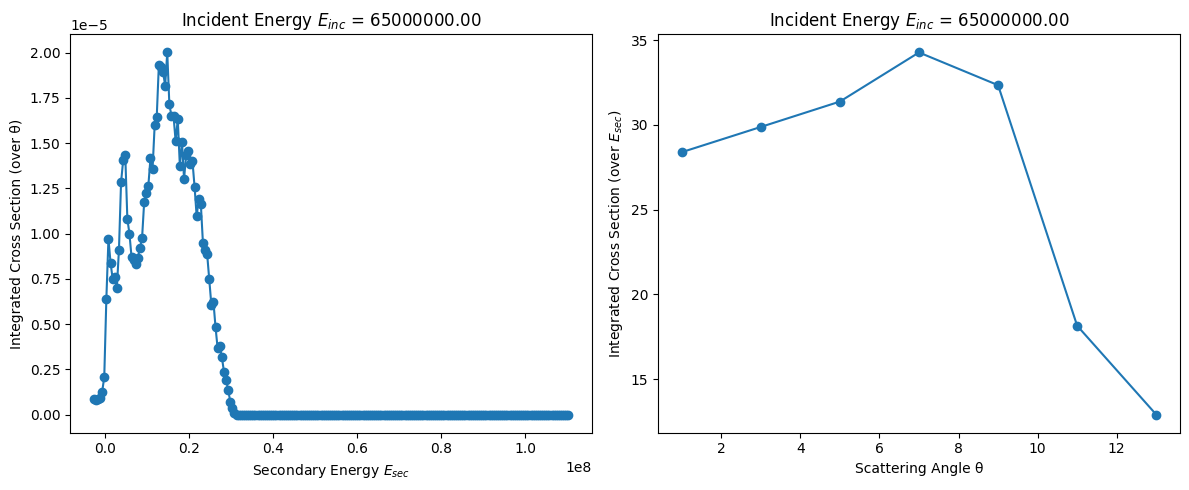

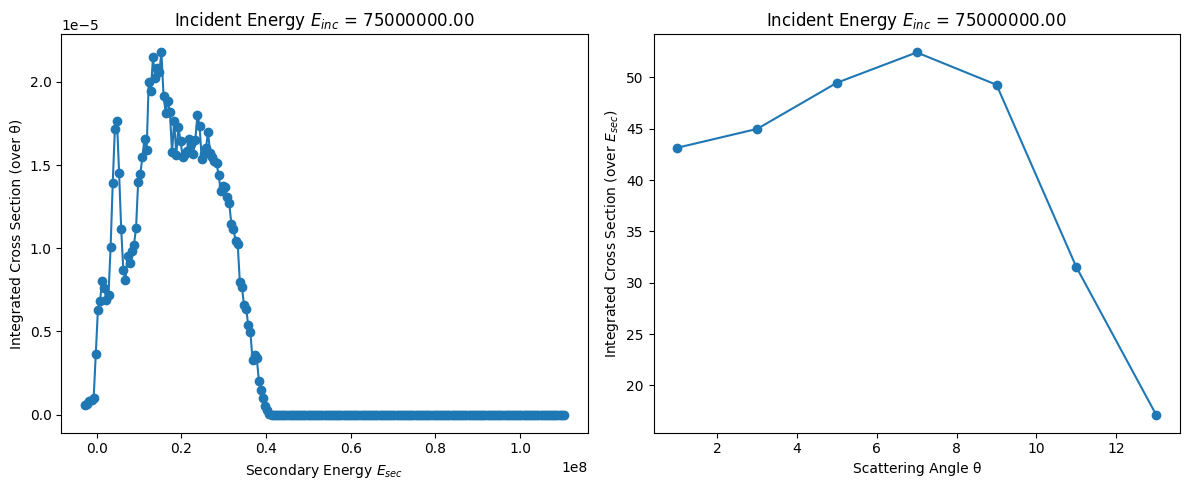

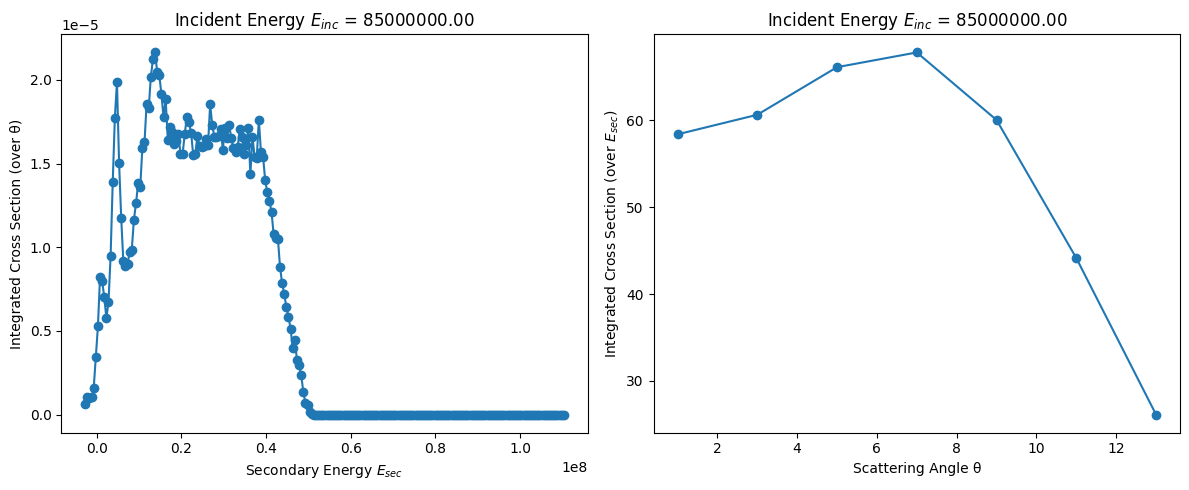

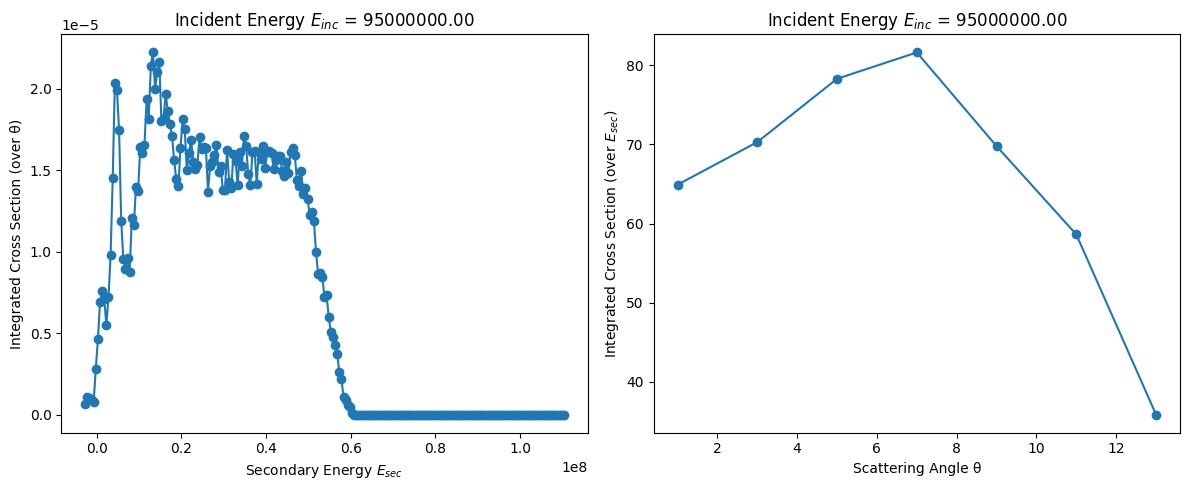

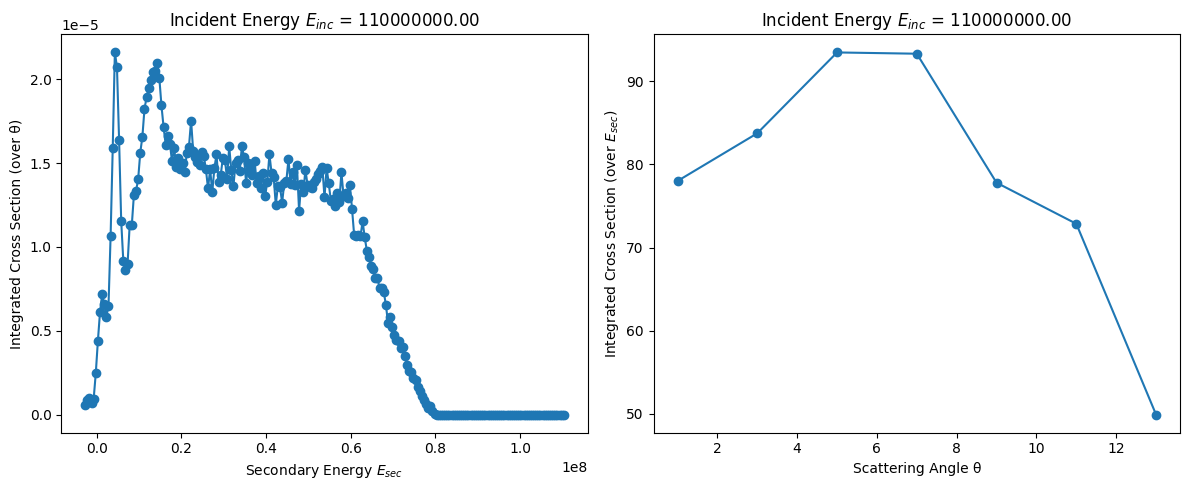

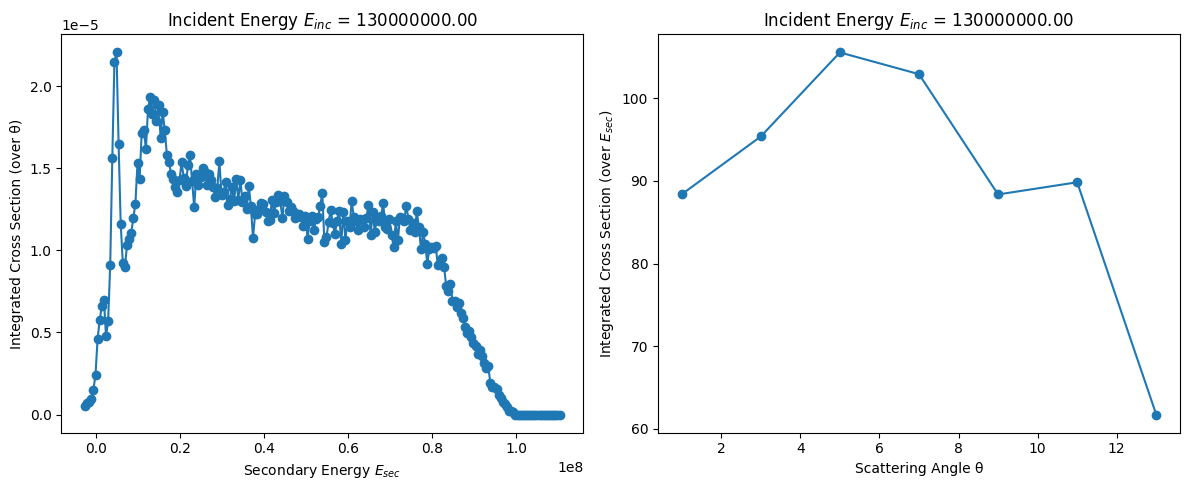

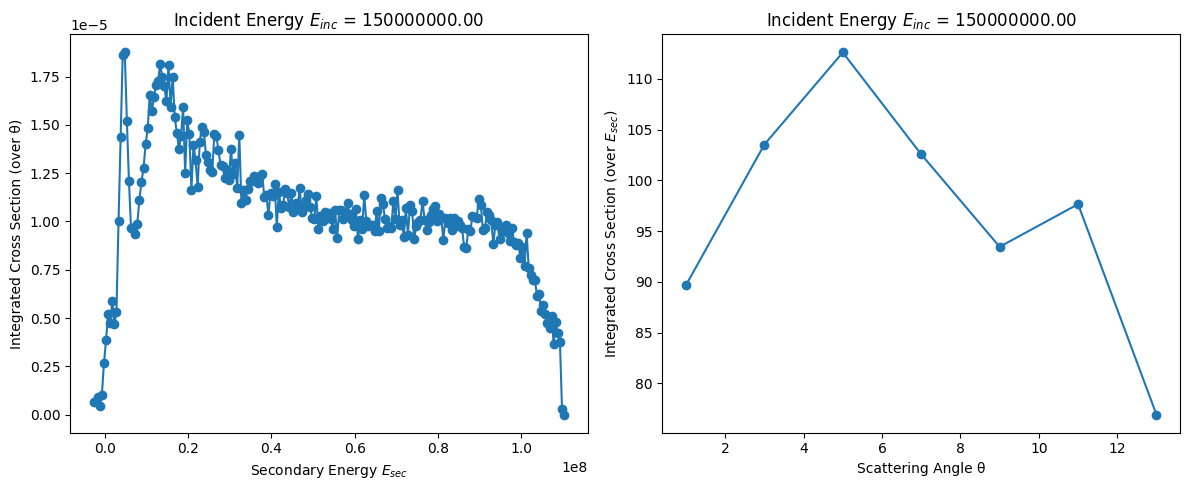

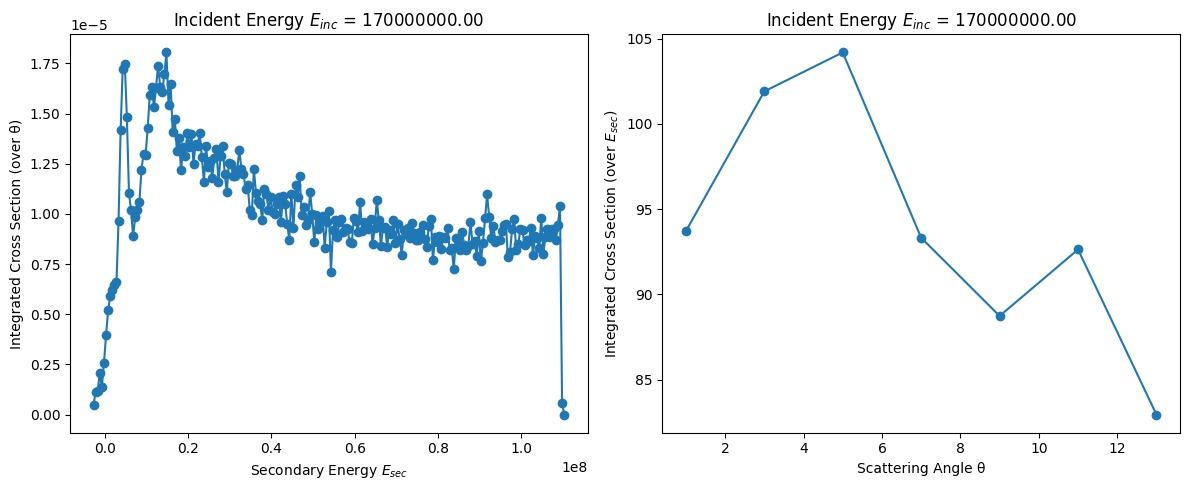

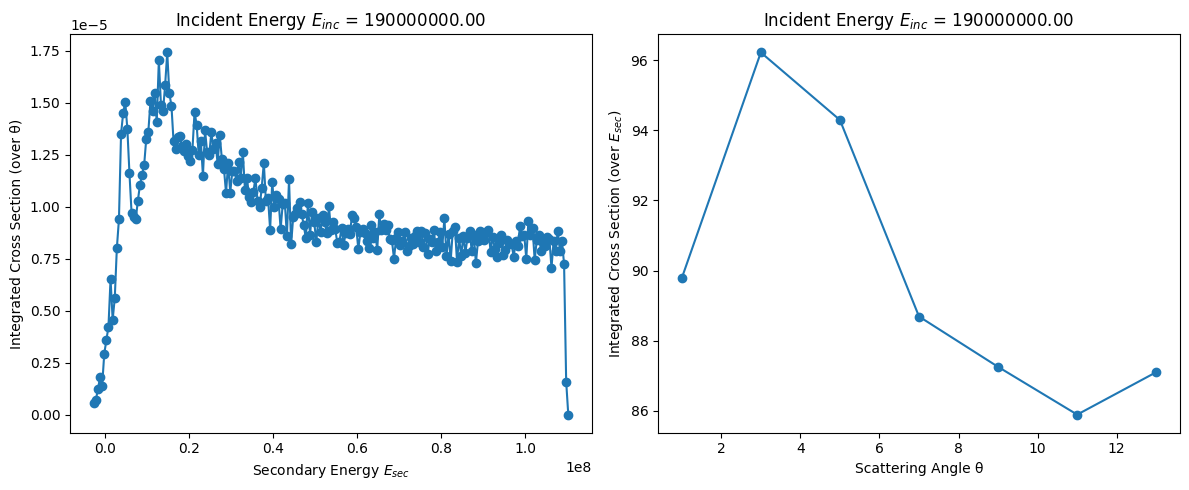

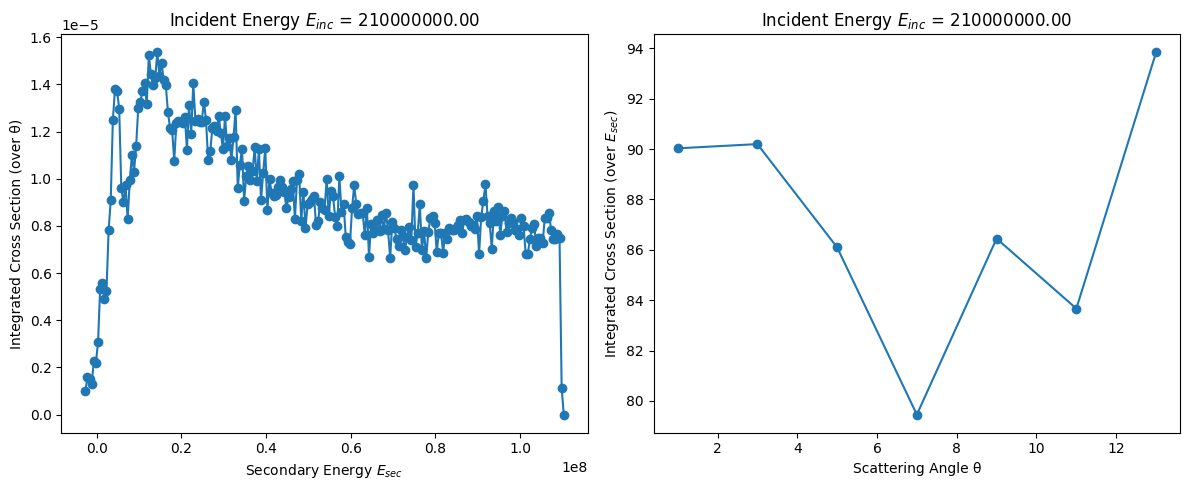

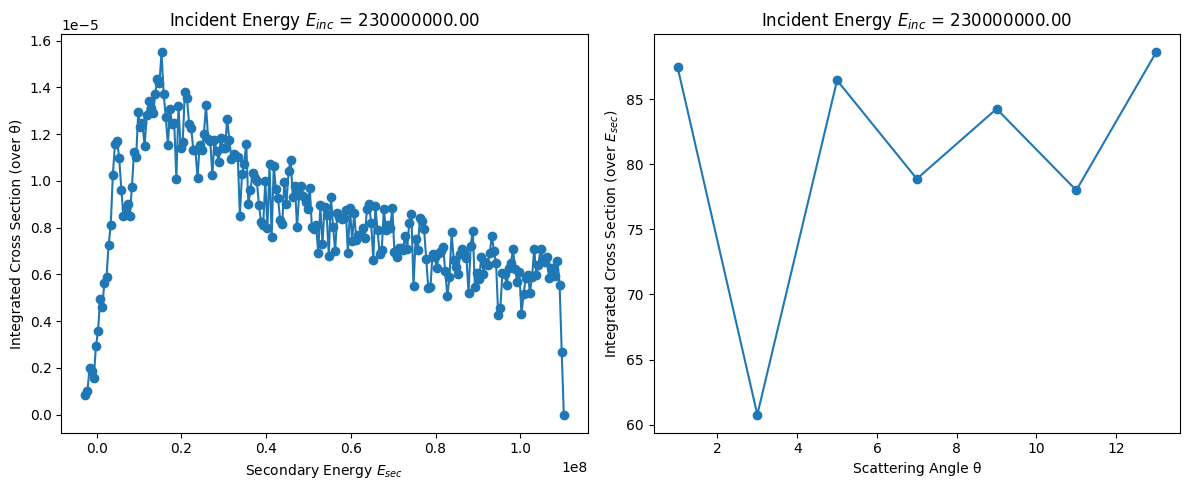

In [6]:


df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

plot_integrated_cross_sections(integrated_results)


# ## Simulator

In [7]:


import math
import torch
import torch.nn as nn
from torch.autograd import Function

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E

        # Ep_com = 0.1 * available_E + 0.9 * r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = 2.0 * r2 - 1.0  # r2 in [0, 1] -> cos(theta) in [-1, 1]
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = 2.0 * torch.pi * r3  # r3 in [0, 1] -> phi in [0, 2π] 

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Differentiable Histogram (much simpler and more stable than KDE)
# ---------------------------
class DifferentiableHistogram(nn.Module):
    def __init__(self, bin_edges, normalize=True):
        super().__init__()
        self.register_buffer("bin_edges", bin_edges.view(-1))
        self.normalize = bool(normalize)
        self.n_bins = len(bin_edges) - 1
        
    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        
        if weights is None:
            weights = torch.ones_like(samples)
        
        # Create histogram using soft binning for differentiability
        bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) / 2
        bin_width = self.bin_edges[1] - self.bin_edges[0]  # Assume uniform bins
        
        # Soft assignment to bins using sigmoid
        # For each sample, compute soft membership to each bin
        samples_expanded = samples.unsqueeze(-1)  # (B, N, 1)
        bin_centers_expanded = bin_centers.view(1, 1, -1)  # (1, 1, n_bins)


                
        tau = getattr(self, "tau", None)
        if tau is None:
            tau = 2.0 * bin_width      # start soft; (larger tau -> softer)
        distances = torch.abs(samples_expanded - bin_centers_expanded)
        soft_assignments = torch.sigmoid((bin_width/2 - distances) / (tau + 1e-12))
                
        # Weight by sample weights
        weights_expanded = weights.unsqueeze(-1)  # (B, N, 1)
        weighted_assignments = soft_assignments * weights_expanded  # (B, N, n_bins)
        
        # Sum over samples to get histogram
        histogram = weighted_assignments.sum(dim=1)  # (B, n_bins)
        
        if self.normalize:
            total_weight = weights.sum(dim=1, keepdim=True).clamp(min=1e-8)
            histogram = histogram / total_weight
        
        return histogram

# ---------------------------
# Minimal Pipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_bins):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.histogram = DifferentiableHistogram(bin_edges=cos_theta_bins, normalize=True)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.histogram(cos_theta_lab, weights=valid)
    
class ECSPipeline(nn.Module):
    def __init__(self, E_bins):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.histogram = DifferentiableHistogram(bin_edges=E_bins, normalize=True)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.histogram(Ep_lab, weights=valid)
    


# ## Network

In [8]:


import torch
import torch.nn as nn
import torch.nn.functional as F


def get_device():
    return torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

def safe_logit(u, eps=1e-6):
    u = u.clamp(min=eps, max=1.0 - eps)
    return torch.log(u) - torch.log1p(-u)

def make_feature_stack(d_in, n_hidden, n_layers):
    layers, d = [], d_in
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden)]
        layers += [nn.LayerNorm(n_hidden)]
        layers += [nn.ReLU()]
        d = n_hidden
    return nn.Sequential(*layers), d

class UniformPreservingMLP(nn.Module):
    """
    Maps [u, λ] -> y in [0,1]^n_out via y = sigmoid(Δ([u,λ]) + logit(u)).
    At init, Δ ≡ 0  => y = u (uniform preserved).
    """
    def __init__(self, n_in, n_lamda, n_hidden, n_layers, n_out=None, eps_logit=1e-6):
        super().__init__()
        if n_out is None:
            n_out = n_in
        assert n_out <= n_in
        self.n_in = n_in
        self.n_lam = n_lamda
        self.n_out = n_out
        self.eps_logit = eps_logit

        self.feats, d_last = make_feature_stack(n_in + n_lamda, n_hidden, n_layers)
        self.head = nn.Linear(d_last, n_out)
        self._init_weights()

    def l1_penalty(self):
        return self.head.weight.abs().sum()

    def _init_weights(self):
        for m in self.feats.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0.0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        # Head: small random init instead of zeros
        nn.init.normal_(self.head.weight, mean=0.0, std=1e-3)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        u = x[..., :self.n_in]
        lam = x[..., self.n_in:self.n_in + self.n_lam]
        h = self.feats(torch.cat([u, lam], dim=-1))
        delta = self.head(h)
        u_head = u[..., :self.n_out]
        z = delta + safe_logit(u_head, eps=self.eps_logit)
        return torch.sigmoid(z)


In [9]:
# class DsigmaLossBinnedNoScale(nn.Module):
#     """
#     Differentiable loss comparing simulated dsigma/dOmega to experimental points,
#     with bin-averaging but no floated scale factor.
#     """
#     def __init__(self, theta_sim_deg, theta_exp_deg, bin_width_deg, exp_sigma, log_space=False):
#         super().__init__()
#         self.theta_sim = theta_sim_deg
#         self.theta_exp = theta_exp_deg
#         self.bin_width = bin_width_deg
#         self.exp_sigma = exp_sigma
#         self.log_space = log_space

#     def forward(self, y_sim, y_exp, n_samples_per_bin=5):
#         """
#         y_sim : (len(theta_sim),) simulated values
#         y_exp : (len(theta_exp),) experimental values
#         n_samples_per_bin : number of points to sample inside each bin
#         """
#         # Compute binned averages
#         y_sim_binned = []
#         for theta_center in self.theta_exp:
#             # sample points inside the bin
#             theta_bin = torch.linspace(
#                 theta_center - self.bin_width/2,
#                 theta_center + self.bin_width/2,
#                 n_samples_per_bin
#             )
#             # interpolate simulation at bin points
#             y_bin = self.linear_interpolate(self.theta_sim, y_sim, theta_bin)
#             # average over bin
#             y_sim_binned.append(torch.mean(y_bin))
#         y_sim_binned = torch.stack(y_sim_binned)

#         # Optional log-space
#         eps = 1e-12
#         if self.log_space:
#             y_sim_binned = torch.log(torch.clamp(y_sim_binned, min=eps))
#             y_exp = torch.log(torch.clamp(y_exp, min=eps))

#         # Weighting
#         if self.exp_sigma is not None:
#             w = 1.0 / (self.exp_sigma**2 + eps)
#         else:
#             w = torch.ones_like(y_exp)

#         # Weighted MSE
#         loss = torch.sum(w * (y_sim_binned - y_exp)**2)
#         return loss, y_sim_binned

#     @staticmethod
#     def linear_interpolate(x, y, x_new):
#         # x: (M,), strictly increasing (cosθ centers)
#         # y: (B, M)
#         # x_new: (n_points,)
#         assert torch.all(x[1:] > x[:-1]), "x must be strictly increasing"

#         indices = torch.searchsorted(x, x_new)
#         indices = torch.clamp(indices, 1, len(x)-1)

#         x0 = x[indices-1]
#         x1 = x[indices]
#         y0 = y[:, indices-1]
#         y1 = y[:, indices]

#         slope = (y1 - y0) / (x1 - x0).unsqueeze(0)
#         y_new = y0 + slope * (x_new.unsqueeze(0) - x0.unsqueeze(0))
#         return y_new  # shape (B, n_points)

class BatchInterpolationLoss(nn.Module):
    """
    Batch-optimized version of the interpolation loss
    """
    
    def __init__(self, exp_theta_degrees):
        super().__init__()
        self.register_buffer('exp_cos_theta', torch.cos(torch.deg2rad(exp_theta_degrees)))
    
    def differentiable_interp1d(self, x, y, x_new):
        """Batch interpolation"""
        x_new_clamped = torch.clamp(x_new, x.min(), x.max())
        indices = torch.searchsorted(x, x_new_clamped, right=False)
        indices = torch.clamp(indices, 1, len(x) - 1)
        
        x0 = x[indices - 1]
        x1 = x[indices]
        
        if y.dim() == 2:  # batch dimension
            y0 = y[:, indices - 1]
            y1 = y[:, indices]
            alpha = (x_new_clamped - x0).unsqueeze(0)
        else:
            y0 = y[indices - 1]
            y1 = y[indices]
            alpha = x_new_clamped - x0
            
        result = y0 + alpha * (y1 - y0)
        return result
    
    def forward(self, sim_cos_theta, sim_dsigma, exp_dsigma):
        """
        Args:
            sim_cos_theta: (n_sim,) simulation grid
            sim_dsigma: (batch_size, n_sim) simulated cross sections
            exp_dsigma: (batch_size, n_exp) experimental cross sections
        """
        # Sort simulation if needed
        if not torch.all(sim_cos_theta[:-1] <= sim_cos_theta[1:]):
            sorted_indices = torch.argsort(sim_cos_theta)
            sim_cos_theta = sim_cos_theta[sorted_indices]
            sim_dsigma = sim_dsigma[:, sorted_indices]
        
        # Interpolate simulation to experimental points
        sim_at_exp_points = self.differentiable_interp1d(
            sim_cos_theta, sim_dsigma, self.exp_cos_theta
        )
        
        # Compute MSE loss
        residuals = sim_at_exp_points - exp_dsigma
        return torch.mean(residuals ** 2)

In [10]:


# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 32      # number of hidden neurons in the network, at each layer
n_layers    = 5       # number of hidden layers in the network (reduced for faster training)
n_out       = n_in    # must match the number of output parameters
batch_size  = 12#40      # samples of random number per batch, to build the distribution. Larger is better, but slower
n_mc_samples = 1000#5_000  # reduced for faster training
epochs      = 1000 #4_000    # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer
l1_lambda   = 1e-3  # L1 regularization strength


print("Using UniformPreservingMLP")
net = UniformPreservingMLP(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)

optimiser = optim.Adam(net.parameters(), lr=lr)

# Maybe AdamW?
# optimiser = optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5)????

# Scheduler to reduce learning rate on plateau
# This will reduce the learning rate if the loss does not improve for a certain number of epochs
# It helps to avoid overshooting the minimum and allows for finer convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode='min', factor=0.2, patience=300, min_lr=1e-5) #, verbose=True)
# ------------------------------------------------------------------


# ## Training

Using UniformPreservingMLP


In [15]:


from tqdm import trange
import matplotlib.pyplot as plt

# ---------------------------
# Create ACS/ECS simulation layer (autograd-friendly)
# ---------------------------
# E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6

# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# Create bin edges from experimental data points
# cos_theta_bins = torch.linspace(cos_theta_exp.min(), cos_theta_exp.max(), len(cos_theta_exp) + 1)

theta_bins = torch.linspace(0,180, 500)
cos_theta_edges = torch.cos(torch.deg2rad(theta_bins))
cos_theta_bins = 0.5 * (cos_theta_edges[:-1] + cos_theta_edges[1:])  # shape (720,)

# E_sec_bins = torch.linspace(E_sec_exp.min(), E_sec_exp.max(), len(E_sec_exp) + 1)

# Prep experimental data
all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6 # (N,)

all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, M)
# all_exp = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, M)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)
num_samples_total = all_Ek.shape[0]

acs_pipeline = ACSPipeline(cos_theta_bins=cos_theta_edges).to(device)
# ecs_pipeline = ECSPipeline(E_bins=E_sec_bins).to(device)

acs_pipeline.histogram.tau = 2.0 * (cos_theta_edges[1]-cos_theta_edges[0]).item()
# ecs_pipeline.histogram.tau = 2.0 * (E_sec_bins[1]-E_sec_bins[0]).item()



# Simple MSE loss for normalized distributions
def mse_normalized_loss(sim, exp, eps=1e-8):
    # Ensure both have the same shape and are valid
    sim = torch.clamp(sim, min=eps)
    exp = torch.clamp(exp, min=eps)
    
    # Normalize distributions
    sim_sum = sim.sum(dim=-1, keepdim=True)
    exp_sum = exp.sum(dim=-1, keepdim=True)
    
    sim_norm = sim / (sim_sum + eps)
    exp_norm = exp / (exp_sum + eps)
    
    # MSE between normalized distributions
    mse_loss = torch.mean((sim_norm - exp_norm) ** 2)
    
    # Add a small term to maintain gradients if distributions are too sparse
    sparsity_penalty = 1e-6 * torch.mean(sim)
    
    return mse_loss + sparsity_penalty


# -------------
# Training loop with better tracking
# -------------

# Track losses
loss_history = []
# mse_loss_history = []
# L1_loss_history = []
epoch_history = []

# ==== Debug toggles ====
USE_FIXED_IDX = False         # True = always use the same idx for Ek
FIXED_IDX_VALUE = 0          # which dataset entry to use if above is True
USE_FIXED_MC = False         # True = use the same MC samples each epoch

# Prepare fixed MC samples if needed
if USE_FIXED_MC:
    fixed_uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

net.train()
print("Starting training...")
print(f"Initial learning rate: {lr}")

for epoch in trange(epochs, desc='Training Epochs'):

    # ----- Index selection -----
    if USE_FIXED_IDX:
        idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
    else:
        idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

    Ek_batch = all_Ek[idx] / 1e3         # (B,)
    dsigma_dOmega_exp = all_exp[idx] # (B, M)

    # ----- MC samples -----
    if USE_FIXED_MC:
        uniform_samples = fixed_uniform_samples
    else:
        uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # ----- Network forward -----
    Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B, N, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)       # (B, N, n_in + 1)
    net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten
    t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)
    t = t.clamp(1e-6, 1 - 1e-6)


    r1 = t[:, :, 0]
    r2 = t[:, :, 1]
    r3 = t[:, :, 2]

    # ----- ACS forward pass -----
    dsigma_dOmega_sim = acs_pipeline(Ek_batch * 1e3, r1, r2, r3)  # (B, M)
   
    # loss_fn_binned = DsigmaLossBinnedNoScale(cos_theta_centers, cos_theta_exp, bin_width_deg=2, exp_sigma=dsigma_dOmega_exp, log_space=False)
    # _, sim_binned = loss_fn_binned(dsigma_dOmega_sim, dsigma_dOmega_exp)

    # # ----- Simple MSE Loss (no extra scaling) -----
    # # mse_loss = mse_normalized_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)
    # mse_loss = mse_normalized_loss(sim_binned, dsigma_dOmega_exp)
    # # l1_loss = l1_lambda * net.l1_penalty()
    # # Combine losses    
    # loss = mse_loss #+ l1_loss


    batch_loss_fn = BatchInterpolationLoss(cos_theta_exp).to(device)
    loss = batch_loss_fn(cos_theta_bins, dsigma_dOmega_sim, dsigma_dOmega_exp)
    # loss = mse_normalized_loss(dsigma_dOmega_sim, dsigma_dOmega_exp) + l1_lambda * net.l1_penalty()

    # must require grad
    assert loss.requires_grad, "Loss got detached — check loss path for item()/detach()/no_grad."

    # ----- Backprop -----
    optimiser.zero_grad(set_to_none=True)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    optimiser.step()

    scheduler.step(loss.detach())


    if (epoch+1) % 50 == 0:
        # decay toward near-hard bins, but not too hard
        acs_pipeline.histogram.tau = max(0.20 * float(cos_theta_bins[1]-cos_theta_bins[0]),
                                        acs_pipeline.histogram.tau * 0.7)
        # ecs_pipeline.histogram.tau = max(0.20 * float(E_sec_bins[1]-E_sec_bins[0]),
        #                                 ecs_pipeline.histogram.tau * 0.7)

    # Track loss AFTER backward (detach here is fine)
    loss_history.append(float(loss.detach()))
    # mse_loss_history.append(float(mse_loss.detach()))
    # L1_loss_history.append(float(l1_loss.detach()))
    epoch_history.append(epoch)



    if epoch % 100 == 0:
        # Calculate gradient norm
        total_grad_norm = 0
        for p in net.parameters():
            if p.grad is not None:
                total_grad_norm += p.grad.norm().item() ** 2
        total_grad_norm = total_grad_norm ** 0.5
        
        print(f"Epoch {epoch+1:3d} | Loss (TOT): {loss.detach().item():.6f} | "
            #   f"Loss (MSE): {mse_loss.detach().item():.6f} | "
            #   f"Loss (L1): {l1_loss.detach().item():.6f} | "
              f"Grad Norm: {total_grad_norm:.6f} | "
              f"Sim sum: {dsigma_dOmega_sim.sum().item():.4f} | "
              f"Exp sum: {dsigma_dOmega_exp.sum().item():.4f} | "
              f"LR: {optimiser.param_groups[0]['lr']:.1e}")
        
        
        


Starting training...
Initial learning rate: 0.001


Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epochs:   0%|          | 1/1000 [00:00<08:57,  1.86it/s]

Epoch   1 | Loss (TOT): 6435.979004 | Grad Norm: 0.021800 | Sim sum: 5987.8579 | Exp sum: 6500.8667 | LR: 2.0e-04


Training Epochs:  10%|█         | 101/1000 [00:29<04:04,  3.67it/s]

Epoch 101 | Loss (TOT): 6305.991699 | Grad Norm: 0.002730 | Sim sum: 5987.9956 | Exp sum: 6553.5459 | LR: 2.0e-04


Training Epochs:  20%|██        | 201/1000 [00:57<03:41,  3.61it/s]

Epoch 201 | Loss (TOT): 6142.576172 | Grad Norm: 0.000001 | Sim sum: 5988.0000 | Exp sum: 6390.5479 | LR: 2.0e-04


Training Epochs:  30%|███       | 301/1000 [01:26<03:17,  3.54it/s]

Epoch 301 | Loss (TOT): 5732.207520 | Grad Norm: 0.000000 | Sim sum: 5988.0000 | Exp sum: 6134.3281 | LR: 4.0e-05


Training Epochs:  38%|███▊      | 381/1000 [01:50<02:58,  3.46it/s]


KeyboardInterrupt: 


=== TRAINING COMPLETE ===
Final loss: 6124.899902
Initial loss: 6435.979004
Loss improvement: 311.079102


NameError: name 'mse_loss_history' is not defined

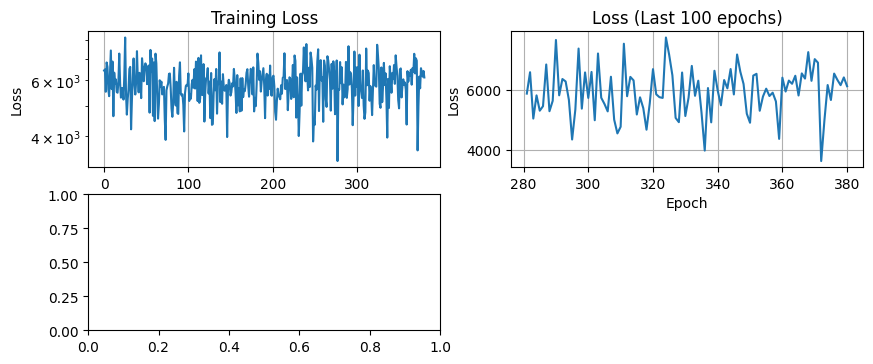

In [16]:



print("\n=== TRAINING COMPLETE ===")
print(f"Final loss: {loss_history[-1]:.6f}")
print(f"Initial loss: {loss_history[0]:.6f}")
print(f"Loss improvement: {loss_history[0] - loss_history[-1]:.6f}")

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.subplot(3, 2, 1)
plt.plot(epoch_history, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(epoch_history[-100:], loss_history[-100:])  # Last 100 epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Last 100 epochs)')
plt.grid(True)

##########

plt.subplot(3, 2, 3)
plt.plot(epoch_history, mse_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Training Loss')
plt.yscale('log')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(epoch_history[-100:], mse_loss_history[-100:])  # Last 100 epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss (Last 100 epochs)')
plt.grid(True)

##########

# plt.subplot(3, 2, 5)
# plt.plot(epoch_history, L1_loss_history)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('L1 Training Loss')
# plt.yscale('log')
# plt.grid(True)

# plt.subplot(3, 2, 6)
# plt.plot(epoch_history[-100:], L1_loss_history[-100:])  # Last 100 epochs
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('L1 Loss (Last 100 epochs)')
# plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:



import torch
import matplotlib.pyplot as plt

net.eval()

n_mc_samples = 5_000
monitor_indices = range(len(integrated_results))  # pick a few energies


for idx in monitor_indices:
    # Experimental values
    Ek_val = integrated_results[idx]['E_inc'] / 1e6 / 1e3 # scalar tensor

    exp_dist = integrated_results[idx]['int_over_E_sec'].to(device)  # (M,)
    # exp_dist = integrated_results[idx]['int_over_theta'].to(device)  # (M,)

    # Shape (B=1, N) for Monte Carlo
    Ek_batch = Ek_val.unsqueeze(0).to(device)  # (1,)
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples)  # (1, N)

    # Random latent samples: (B=1, N, n_in)
    uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)

    # Append Ek to each MC sample row: (1, N, n_in+1)
    net_input = torch.cat([uniform_samples, Ek_expanded.unsqueeze(-1)], dim=-1)

    # Flatten for net: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    with torch.no_grad():
        t = net(net_input_flat).reshape(1, n_mc_samples, n_in)
        r1 = t[:, :, 0]
        r2 = t[:, :, 1]
        r3 = t[:, :, 2] 

        # Now acs_pipeline gets (B=1, N) inputs for r1, r2, r3
        sim_dist = acs_pipeline(Ek_batch * 1e3, r1, r2, r3).squeeze(0)  # (M,)
        # print(sim_dist.shape, cos_theta_bins.shape)
        sim_dist = sim_dist * exp_dist.sum() / (sim_dist.sum() + 1e-8)  # Normalize to match experimental scale
        # sim_dist = ecs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)

    # Plot
    plt.figure()
    plt.plot(cos_theta_exp.cpu(), exp_dist.cpu(), label='Experimental')
    plt.plot(cos_theta_bins.cpu(), sim_dist.cpu(), label='Simulation')
    plt.xlabel(r'$\cos(\theta)$')
    # plt.xlim(0, 2)

    # plt.plot(E_sec_exp.cpu(), exp_dist.cpu(), label='Experimental')
    # plt.plot(E_sec_exp.cpu(), sim_dist.cpu(), label='Simulation')
    # plt.xlabel(r'$E_{\text{sec}}$ [MeV]')
    
    plt.ylabel(r'$d\sigma/d\Omega$')
    plt.title(f'E_inc = {Ek_val.item():.2f} MeV')
    plt.legend()
    plt.show()


# ## Testing

In [ ]:


Ek_batch = torch.tensor([[[0.095] for m in range(n_mc_samples)] for b in range(batch_size)], device=device)  # Example incident energies in MeV, one for each batch

uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

# ----- Network forward -----


net_input = torch.cat([uniform_samples, Ek_batch/100], dim=-1)       # (B, N, n_in + 1)

print("Shape of net_input before flattening:", net_input.shape)

net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten

print("Shape of net_input_flat:", net_input_flat.shape)

t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)


print("Shape of t after network forward:", t.shape)

print(net_input[0, :, 0])
print(t[0, :, 0])

Shape of net_input before flattening: torch.Size([40, 5000, 4])
Shape of net_input_flat: torch.Size([200000, 4])
Shape of t after network forward: torch.Size([40, 5000, 3])
tensor([0.4006, 0.3094, 0.7700,  ..., 0.5432, 0.1069, 0.0435], device='mps:0')
tensor([0.3801, 0.2926, 0.7544,  ..., 0.5220, 0.0997, 0.0404], device='mps:0',
       grad_fn=<SelectBackward0>)
